# Zajęcia 1 - Modelowanie Wieloagentowe - El Farol

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#Define-agent-struct" data-toc-modified-id="Define-agent-struct-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define agent struct</a></span></li><li><span><a href="#Auxilary-functions" data-toc-modified-id="Auxilary-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Auxilary functions</a></span></li><li><span><a href="#Generating-agents-and-assigning-strategies" data-toc-modified-id="Generating-agents-and-assigning-strategies-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Generating agents and assigning strategies</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Base-model" data-toc-modified-id="Base-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Base model</a></span></li><li><span><a href="#Parameters-analysis" data-toc-modified-id="Parameters-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Parameters analysis</a></span><ul class="toc-item"><li><span><a href="#Memory-size" data-toc-modified-id="Memory-size-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Memory size</a></span></li><li><span><a href="#Number-of-strategies" data-toc-modified-id="Number-of-strategies-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Number of strategies</a></span></li><li><span><a href="#Crowdedness-threshold" data-toc-modified-id="Crowdedness-threshold-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Crowdedness threshold</a></span></li></ul></li></ul></li><li><span><a href="#Literature" data-toc-modified-id="Literature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Literature</a></span></li></ul></div>

## Description

El Farol is a bar in Santa Fe, New Mexico. The bar is popular - especially on Thursday nights when they offer Irish music - but sometimes becomes overcrowded and unpleasant. In fact, if the patrons of the bar think it will be overcrowded they stay home; otherwise they go enjoy themselves at El Farol. This model explores what happens to the overall attendance at the bar on these popular Thursday evenings, as the patrons use different strategies for determining how crowded they think the bar will be.

El Farol was originally put forth by Brian Arthur (1994) as an example of how one might model economic systems of boundedly rational agents who use inductive reasoning.

This model is from Chapter Three of the book "Introduction to Agent-Based Modeling: Modeling Natural, Social and Engineered Complex Systems with NetLogo", by Uri Wilensky & William Rand.

Bar customers have limited rationality in their choices. They rely on intuitive analysis of bar visit patterns and predicting the behavior of other customers. Based on the information available, they create different strategies and use those, that predict attendance at El Farol well. If there are changes in the process and picked strategy is not effective anymore, new strategy will replace it over time - customers use inductive reasoning.



In order to simulate the task, a multi-agent model was created based on the following
assumptions:
1. Each agent is assigned a fixed number of random strategies. Prediction of bar attendace in i-th week back for n-th strategy is defined as:

$$S_n(f_i) = a_{1,n}f_{i+1} + a_{2,n}f_{i+2} + ... + a_{k,n}f_{i+k}$$

where $a_{1,n}, a_{2,n}, ..., a_{k,n}$ are random coefficients from $<-1;1>$. Prediction
_ex ante_ for upcoming week is then:

$$S_n(f_0) = a_{1,n}f_1 + a_{2,n}f_2 + ... + a_{k,n}f_k$$

For $i > 0$ formula return prediction _ex post_.
2. Agent strategies take into account k earlier attendance values, where k is specified as the agent's "memory".
3. At each simulation step, agents determine the best strategy $S_{best}$ from the assigned set of strategies that will be used to predict attendance at a given step. Best strategy minimizes an error:
$$\epsilon_n = \sum^k_{i=1}|f_i − S_n(f_i)|$$
4. If the predicted attendance for the next week is lower than the congestion threshold the agent decides to visit the bar. Otherwise, the agent decides to stay home.
$$Attend = \begin{cases}1 & S_{best}(f_0) \leq crowd\_threshold\\0 & S_{best}(f_0) > crowd\_threshold\end{cases}$$

Simulation parameters:

|Parameter name| Description|
|---------------|---------------|
|Memory_size| Number of history attendance values used in prediction|
|N_of_strategies| Size of agent's strategy set|
|Crowd_threshold| Threshold of bar crowdedness|
|Num_agents| Number of agents|
|Sim_ticks| Number of weeks simulated|

## Code

Authors: 
* Łukasz Kraiński https://github.com/KrainskiL
* Aleksander Nosarzewski https://github.com/nosarzewski


In [1]:
using Plots
using Statistics

### Define agent struct

In [2]:
mutable struct Drinker
    ID::Int64
    strategies::Matrix{Float64}  # list of strategies to choose from
    best_strategy::Int64 # index of currently best strategy
    intention::Bool # whether agent intends to go to El Farol in this iteration
    prediction::Int64 # predicted attendance
end

### Auxilary functions

Function generating `n` random strategies for `memory` upcoming weeks

In [3]:
function generate_strategies(n::Int64, memory::Int64)
    #weights for each week are random floats from -1 to 1
    strategies_set = 1 .- 2 * rand(n, memory)
    return strategies_set
end

generate_strategies (generic function with 1 method)

Function calculating predicted attendance for set of strategies

In [4]:
function predict_attendance(s_set::Matrix{Float64}, timeframe::Vector{Int64})
    #Multiplying attendance vector and weights matrix + constant
    #Return vector of predictions for each strategy
    return round.(Int, 100 .* s_set[:, 1] + s_set[:, 2:end] * timeframe)
end

predict_attendance (generic function with 1 method)

Prediction for single strategy

In [5]:
function predict_attendance(strategy::Vector{Float64}, timeframe::Vector{Int64})
    #Multiplying attendance vector and weights vector + constant
    #Return single prediction for given strategy
    return round(Int, strategy[1] * 100 + strategy[2:end]' * timeframe)
end

predict_attendance (generic function with 2 methods)

Function finding best strategy for given set

In [6]:
function update_best_strategy(s_set::Matrix{Float64}, timeframe::Vector{Int64}, mem_size::Int64)
    #Initialize errors vector with 0
    n = size(s_set, 1)
    errors_vector = zeros(n)
    #Calculate errors 'memory_size' times and sum them
    #Error = abs(attendance_i_week_back - predicted_attendance_i_week_back)
    week = 1
    for i in 1:mem_size
        predicted = predict_attendance(s_set, timeframe[(i+1):(i + mem_size)])
        errors_vector += abs.(timeframe[i] .- predicted)
    end
    #Return index of minimal error
    return argmin(errors_vector)
end

update_best_strategy (generic function with 1 method)

### Generating agents and assigning strategies

Function for setting up an experiment

In [7]:
function setup(n_agents::Int64, n_strategies::Int64, mem_size::Int64)
    #Generating random bar attendance history to start the model
    attendance_history = rand(0:n_agents, mem_size * 2)
    #Initialize vector of agents
    Agents = [Drinker() for i = 1:n_agents]
    #Setting up agents
    for (ind, a) in enumerate(Agents)
        a.ID = ind
        a.strategies = generate_strategies(n_strategies, mem_size + 1)
        a.best_strategy = rand(1:n_strategies, 1)[1]
    end
    #Return initial attendance history vector and array of agents
    return attendance_history, Agents
end

setup (generic function with 1 method)

Function for running experiment

In [9]:
function run_simulation(history::Array{Int64}, Agents::Array{Drinker}, n_ticks::Int64,
                        n_agents::Int64, crowd_thresh::Int64, mem_size::Int64)
    for i in 1:n_ticks
        #Update prediction and agent's decision for current tick
        for a in Agents
            a.prediction = predict_attendance(a.strategies[a.best_strategy, :], history[1:mem_size])
            a.intention = a.prediction <= crowd_thresh
        end
        #Count bar attendance in given tick
        tick_attendance = sum([Agents[j].intention for j = 1:n_agents])
        #Update attendance history
        history = [tick_attendance; history]
        #Update agents' best strategies
        for a in Agents
            a.best_strategy = update_best_strategy(a.strategies, history[1:(2 * mem_size)], mem_size)
        end
    end
    return reverse(history), Agents
end

run_simulation (generic function with 1 method)

## Analysis

### Base model

In [10]:
struct Input
    num_agents::Int64
    sim_ticks::Int64
    crowd_threshold::Int64
    memory_size::Int64
    num_of_strategies::Int64
end

In [11]:
# Base model constructor
In_base = Input(100, 100, 60, 5, 10)
#Default constructor
Drinker() = Drinker(0, zeros(In_base.num_of_strategies, In_base.memory_size), 0, 0, 0)

# Setting up base experiment
attendance_history_setup, Agents_setup = setup(In_base.num_agents, In_base.num_of_strategies, In_base.memory_size)
# Running experiment
attendance_history, Agents = run_simulation(attendance_history_setup, Agents_setup, In_base.sim_ticks, In_base.num_agents,
                                            In_base.crowd_threshold, In_base.memory_size);

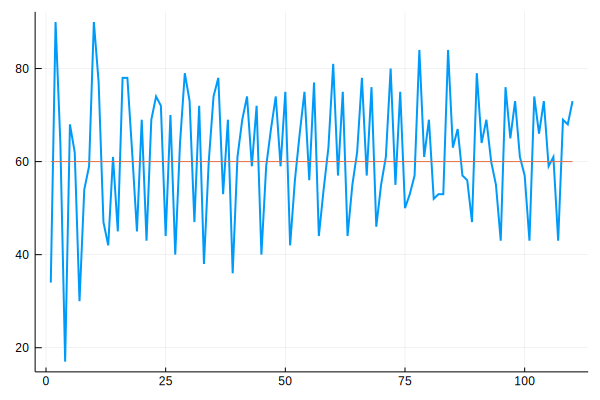

In [12]:
plot(attendance_history, lw = 2)
att_len = length(attendance_history)
plot!(1:att_len,fill(60,att_len), legend = false)

### Parameters analysis

In [13]:
function plot_results(n::Int, 
        k::Int, 
        results::Matrix{<:Real}, 
        thresh::Int, 
        title::String)
    rows, cols = size(results)
    scatter(repeat(1:rows,inner=k),reshape(transpose(results[:,((n-1)*k+1):k*n]),rows*k), 
        alpha =0.1, ylim = [0,100], color="grey")
    plot!(1:rows,fill(thresh,rows), lw =3, color="red")
    plot!(1:rows,mean(results[:,((n-1)*k+1):k*n], dims=2), lw = 2, color="blue",
        legend = false, title = title)
end

plot_results (generic function with 1 method)

#### Memory size

In [14]:
k = 10
mem_size_grid = vcat(collect(1:2:7), 10)
result_mem_size = Array{Int64}(undef, In_base.sim_ticks, 0)
for grid_val in mem_size_grid
    for i in 1:k
        attendance_history_setup, Agents_setup = setup(In_base.num_agents, In_base.num_of_strategies, grid_val)
        attendance_history, Agents = run_simulation(attendance_history_setup, Agents_setup, In_base.sim_ticks, In_base.num_agents,
                                                    In_base.crowd_threshold, grid_val)
        result_mem_size = hcat(result_mem_size, attendance_history[(grid_val * 2 + 1):end])
    end
end

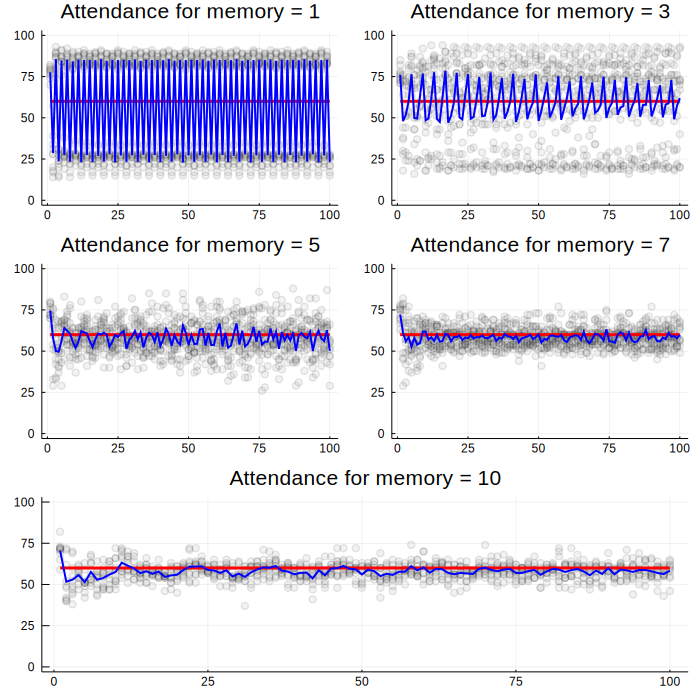

In [15]:
plot([plot_results(i,k,result_mem_size,In_base.crowd_threshold,
            "Attendance for memory = $(mem_size_grid[i])") for i in 1:5]...,size = (700,700),
            layout=@layout [a b; c d ; e])

#### Number of strategies

In [ ]:
k = 10
n_strat_grid = vcat(1, collect(5:5:20))
result_n_strat = Array{Int64}(undef, In_base.sim_ticks, 0)
for grid_val in n_strat_grid
    for i in 1:k
        attendance_history_setup, Agents_setup = setup(In_base.num_agents, grid_val, In_base.memory_size)
        attendance_history, Agents = run_simulation(attendance_history_setup, Agents_setup, In_base.sim_ticks, In_base.num_agents,
                                                    In_base.crowd_threshold, In_base.memory_size)
        result_n_strat = hcat(result_n_strat, attendance_history[(In_base.memory_size * 2 + 1):end])
    end
end

In [ ]:
plot([plot_results(i,k,result_n_strat,60,"Attendance for no. strategies = $(n_strat_grid[i])") for i in 1:5]...,size = (700,700),
            layout=@layout [a b; c d ; e])

#### Crowdedness threshold

In [ ]:
k = 10
crowd_thresh_grid = collect(0:20:100)
result_crowd_thresh = Array{Int64}(undef, In_base.sim_ticks, 0)
for grid_val in crowd_thresh_grid
    for i in 1:k
        attendance_history_setup, Agents_setup = setup(In_base.num_agents, In_base.num_of_strategies, In_base.memory_size)
        attendance_history, Agents = run_simulation(attendance_history_setup, Agents_setup, In_base.sim_ticks, In_base.num_agents,
                                                    grid_val, In_base.memory_size)
        result_crowd_thresh = hcat(result_crowd_thresh, attendance_history[(In_base.memory_size * 2 + 1):end])
    end
end

In [ ]:
plot([plot_results(i,k,result_crowd_thresh, crowd_thresh_grid[i],
            "Crowdedness threshold = $(crowd_thresh_grid[i])") for i in 1:6]...,size = (700,700),
            layout=@layout [a b; c d ; e f])

## Literature

* Arthur, W. B. Inductive reasoning and bounded rationality. The American Economic
Review 84 (2) (1994), 406–411.

* Wilensky, U., and Rand, W. An Introduction to Agent-Based Modeling. MIT Press,
2015.
